In [1]:
import pandas as pd
import numpy as np
import math
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:00, 34.78it/s]


(179297, 11)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [7]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [8]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [9]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [10]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [11]:
target_gu = '동대문구'
target_dong = '장안동'
target_purpose = '3종일반'
target_building_age = 5
target_period = 18 # in months

In [12]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(184, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
163591,서울특별시 동대문구 장안동 415-1,천호대로77길 10,양지 쉐르빌아파트,68.65,33000,2,2016.0,4.0,2020-10-19,480.699199,5.0,대,511.7,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동
163603,서울특별시 동대문구 장안동 382-5,장한로21길 11-10,태솔아파트1차,76.86,32000,2,2016.0,4.0,2020-12-28,416.341400,5.0,대,1172.0,일반상업지역,제3종일반주거지역,업무용,평지,세로장방,소로각지,동대문구,장안동
163604,서울특별시 동대문구 장안동 382-5,장한로21길 11-10,태솔아파트1차,79.53,34500,2,2016.0,5.0,2021-01-16,433.798567,5.0,대,1172.0,일반상업지역,제3종일반주거지역,업무용,평지,세로장방,소로각지,동대문구,장안동
166801,서울특별시 동대문구 장안동 374-9,한천로24길 74-7,가우디트윈캐슬1,53.22,29500,7,2016.0,5.0,2021-01-18,554.302894,5.0,대,331.7,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동
166815,서울특별시 동대문구 장안동 335-7,,젬스톤 힐즈,76.22,31800,5,2017.0,3.0,2020-02-07,417.213330,4.0,대,431.3,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동


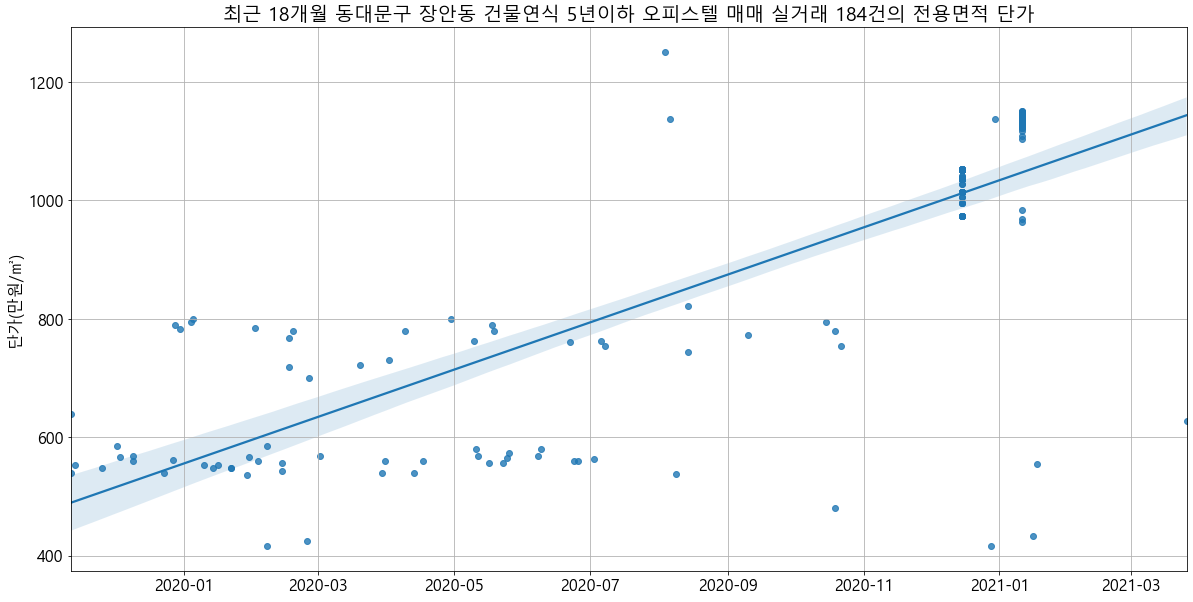

In [14]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [15]:
concat_df = pd.concat([target_df])

In [16]:
concat_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
163591,서울특별시 동대문구 장안동 415-1,천호대로77길 10,양지 쉐르빌아파트,68.65,33000,2,2016.0,4.0,2020-10-19,480.699199,5.0,대,511.7,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동
163603,서울특별시 동대문구 장안동 382-5,장한로21길 11-10,태솔아파트1차,76.86,32000,2,2016.0,4.0,2020-12-28,416.341400,5.0,대,1172.0,일반상업지역,제3종일반주거지역,업무용,평지,세로장방,소로각지,동대문구,장안동
163604,서울특별시 동대문구 장안동 382-5,장한로21길 11-10,태솔아파트1차,79.53,34500,2,2016.0,5.0,2021-01-16,433.798567,5.0,대,1172.0,일반상업지역,제3종일반주거지역,업무용,평지,세로장방,소로각지,동대문구,장안동
166801,서울특별시 동대문구 장안동 374-9,한천로24길 74-7,가우디트윈캐슬1,53.22,29500,7,2016.0,5.0,2021-01-18,554.302894,5.0,대,331.7,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동
166815,서울특별시 동대문구 장안동 335-7,,젬스톤 힐즈,76.22,31800,5,2017.0,3.0,2020-02-07,417.213330,4.0,대,431.3,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동


In [17]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [18]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(184, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
0,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,74.99,42500,3,2019.0,0.0,2019-12-03,566.742232,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482
1,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,74.99,42500,4,2019.0,1.0,2020-01-30,566.742232,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482
2,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,68.03,38700,4,2019.0,1.0,2020-03-02,568.866676,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482
3,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,68.03,39500,3,2019.0,1.0,2020-05-11,580.626194,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482
4,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,68.53,38900,4,2019.0,1.0,2020-05-12,567.634613,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482


In [19]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(13, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
13,서울특별시 동대문구 장안동 335-10,답십리로 292-3,태솔아파트4차,74.99,42300,2,2019.0,1.0,2020-07-03,564.075210,2.0,대,908.5,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,566.789482
15,서울특별시 동대문구 장안동 335-7,,젬스톤 힐즈,74.48,31600,4,2017.0,3.0,2020-02-25,424.274973,4.0,대,431.3,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동,420.744151
37,서울특별시 동대문구 장안동 337-1,장한로26길 40,마하나임,51.59,28900,5,2019.0,1.0,2020-04-17,560.186083,2.0,대,232.0,일반상업지역,지정되지않음,업무용,평지,부정형,소로각지,동대문구,장안동,553.974449
38,서울특별시 동대문구 장안동 346-1,장한로26가길 53,태솔아파트3차,66.46,35800,2,2018.0,2.0,2020-08-09,538.669877,3.0,대,1326.5,일반상업지역,지정되지않음,상업기타,평지,사다리형,소로각지,동대문구,장안동,538.669877
113,서울특별시 동대문구 장안동 365-9,장한로 98,케이타워,22.68,25807,14,2020.0,0.0,2020-12-30,1137.874780,1.0,대,819.8,일반상업지역,지정되지않음,상업기타,평지,정방형,광대로한면,동대문구,장안동,1032.737441
115,서울특별시 동대문구 장안동 371-4,장한로 121,장안동 퍼스티지 더올림,17.77,14593,12,2020.0,0.0,2020-08-14,821.215532,1.0,대,341.9,일반상업지역,지정되지않음,업무용,평지,사다리형,광대로한면,동대문구,장안동,782.672282
116,서울특별시 동대문구 장안동 372-12,장한로 107,아르떼하임,63.53,39900,4,2019.0,2.0,2021-03-26,628.049740,2.0,대,463.0,일반상업지역,지정되지않음,상업기타,평지,세로장방,광대로한면,동대문구,장안동,628.049740
117,서울특별시 동대문구 장안동 374-9,한천로24길 74-7,가우디트윈캐슬1,53.22,29500,7,2016.0,5.0,2021-01-18,554.302894,5.0,대,331.7,일반상업지역,지정되지않음,상업기타,평지,세로장방,소로한면,동대문구,장안동,554.302894
119,서울특별시 동대문구 장안동 382-5,장한로21길 11-10,태솔아파트1차,79.53,34500,2,2016.0,5.0,2021-01-16,433.798567,5.0,대,1172.0,일반상업지역,제3종일반주거지역,업무용,평지,세로장방,소로각지,동대문구,장안동,425.069983
120,서울특별시 동대문구 장안동 415-1,천호대로77길 10,양지 쉐르빌아파트,68.65,33000,2,2016.0,4.0,2020-10-19,480.699199,5.0,대,511.7,일반상업지역,지정되지않음,상업기타,평지,가로장방,소로각지,동대문구,장안동,480.699199


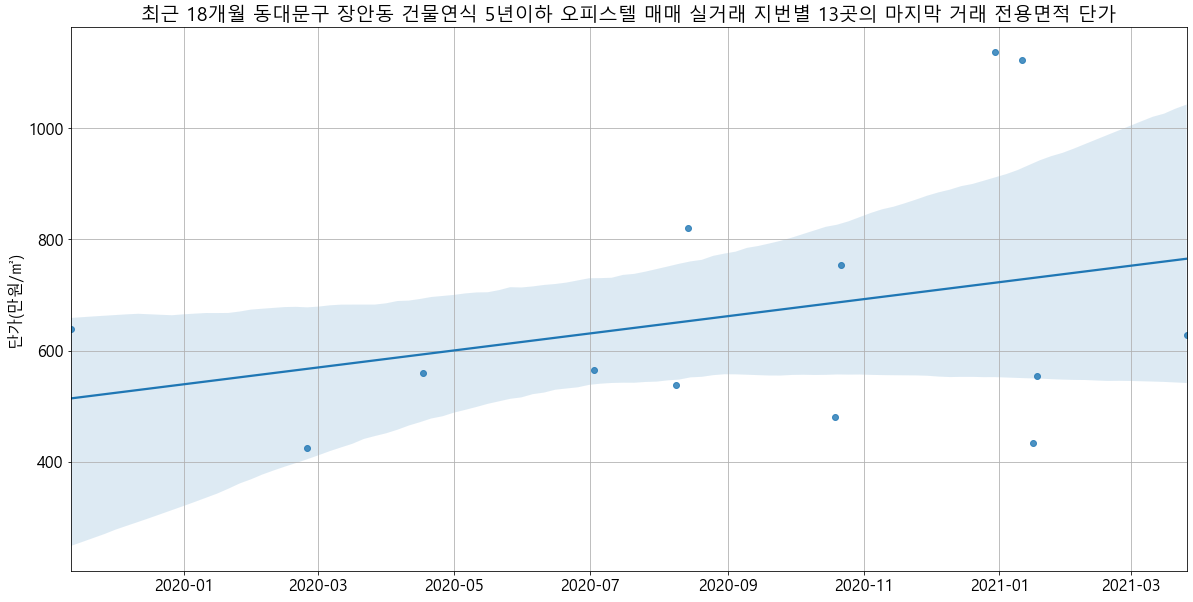

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

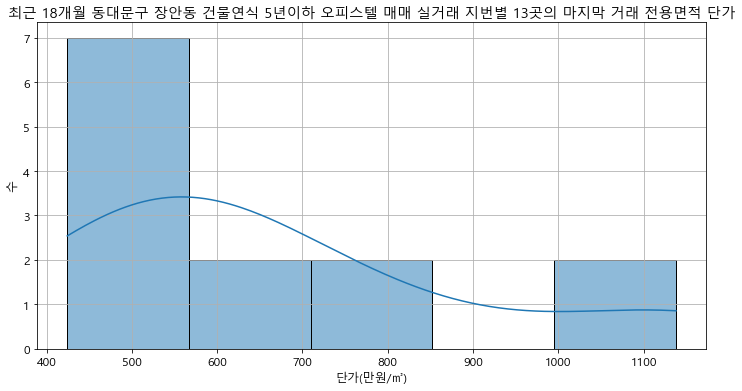

<Figure size 432x288 with 0 Axes>

In [21]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [22]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [23]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건물연식', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건물연식,계약날짜,단가(만원/㎡),용도지역명1
0,서울특별시 동대문구 장안동 335-10,태솔아파트4차,2.0,2020-07-03,564.075210,일반상업지역
1,서울특별시 동대문구 장안동 335-7,젬스톤 힐즈,4.0,2020-02-25,424.274973,일반상업지역
2,서울특별시 동대문구 장안동 337-1,마하나임,2.0,2020-04-17,560.186083,일반상업지역
3,서울특별시 동대문구 장안동 346-1,태솔아파트3차,3.0,2020-08-09,538.669877,일반상업지역
4,서울특별시 동대문구 장안동 365-9,케이타워,1.0,2020-12-30,1137.874780,일반상업지역
5,서울특별시 동대문구 장안동 371-4,장안동 퍼스티지 더올림,1.0,2020-08-14,821.215532,일반상업지역
6,서울특별시 동대문구 장안동 372-12,아르떼하임,2.0,2021-03-26,628.049740,일반상업지역
7,서울특별시 동대문구 장안동 374-9,가우디트윈캐슬1,5.0,2021-01-18,554.302894,일반상업지역
8,서울특별시 동대문구 장안동 382-5,태솔아파트1차,5.0,2021-01-16,433.798567,일반상업지역
9,서울특별시 동대문구 장안동 415-1,양지 쉐르빌아파트,5.0,2020-10-19,480.699199,일반상업지역


In [25]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)

In [ ]:
%%time
land_plans_df = pd.read_csv('./토지이용계획정보/original_land_plans_mapped.csv')
land_plans_df = land_plans_df.sort_values(['지번주소', '년']).drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년']).reset_index(drop=True)
print(land_plans_df.shape)
land_plans_df.head()

In [ ]:
from time import sleep
import requests
from urllib.parse import urlparse

# 지번주소로 도로명주소와 좌표를 다운로드함. 출처 - 행정안전부 도로명주소 안내시스템 개발자센터

def fetch_coor_data(addr_list):
    roadname_url = 'https://www.juso.go.kr/addrlink/addrLinkApi.do?'
    roadname_apikey = 'devU01TX0FVVEgyMDIxMDUwNDE1NTMwMDExMTEyNzc='
    coor_base_url = 'https://www.juso.go.kr/addrlink/addrCoordApi.do?'
    coor_apikey = 'devU01TX0FVVEgyMDIxMDIyNjExMDQwMDExMDg1ODU='
    # 도로명주소 검색 api key 만료일 2021년 8월 2일
    # 좌표검색 api key 만료일 2021년 5월 27일
    #apikey 만료시 https://www.juso.go.kr/addrlink/devAddrLinkRequestWrite.do?returnFn=write&cntcMenu=URL 가서 새로 받을 것.
    
    coor_data_df = pd.DataFrame({'지번주소':[], '도로명주소':[], 'x좌표':[], 'y좌표':[]})
    
    for i, address in enumerate(addr_list):     
        address_no_zero = address
        
        roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=5' + '&keyword=' \
                                       + address_no_zero + '&resultType=json' + '&hstryYn=Y')
        sleep(1)
        roadname_info = roadname_result.json()['results']['juso']
        
        if roadname_info == []:
            print(address_no_zero)
            if address_no_zero.endswith('-0'):
                address_no_zero = address_no_zero[:-2]
            
            roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=5' + '&keyword=' \
                                       + address_no_zero + '&resultType=json' + '&hstryYn=Y')
            sleep(1)
            roadname_info = roadname_result.json()['results']['juso']
            
            if roadname_info == []:
                print(address)
                print('was not able to get roadname info')
            
                continue
                                
        roadname_info = roadname_info[0]               
        
        coor_result = requests.get(coor_base_url + 'confmKey=' + coor_apikey + '&admCd=' + roadname_info['admCd']\
                                   + '&rnMgtSn=' + roadname_info['rnMgtSn'] + '&udrtYn=' + roadname_info['udrtYn']\
                                   + '&buldMnnm=' + roadname_info['buldMnnm'] + '&buldSlno=' + roadname_info['buldSlno']\
                                   + '&resultType=json')
        sleep(1)
        #return coor_result
        
        if coor_result.json()['results']['juso'] == None:
            print(address_no_zero)
            continue
        
        coor_info = coor_result.json()['results']['juso'][0]
        
        coor_x = pd.to_numeric(coor_info['entX'])
        coor_y = pd.to_numeric(coor_info['entY'])
        
        roadname_addr = roadname_info['roadAddrPart1']
        
        coor_data_df.loc[i,'지번주소'] = address
        coor_data_df.loc[i,'도로명주소'] = roadname_addr
        coor_data_df.loc[i, 'x좌표'] = coor_x
        coor_data_df.loc[i, 'y좌표'] = coor_y
        
    
    
    return coor_data_df

In [ ]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [ ]:
def get_year(x):
    if pd.isna(x) == True:
        return x
    else:
        return int(x.split('.')[0])

In [ ]:
def date_modifier(x):
    # x is a string or datetime
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if '-' in x:
            x = x.replace('-', '.')
            
        splitted = x.split('.')
        
        if len(splitted) == 1:
            return np.nan
        else:
            return x.split(' ')[0]

In [ ]:
def get_bd_type(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '오피' in x:
            return '오피스텔'
        else:
            return '연립다세대'

In [ ]:
model_names = [f for f in os.listdir('./Training/training_data_ver_22/') if ('catboost_multiclass' in f) & ('lower_lr' not in f)]
model_names

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
basedir = './Training/training_data_ver_22/'
models_list = []
for name in tqdm(model_names):
    model = CatBoostClassifier().load_model(basedir + name)
    models_list.append(model)

In [ ]:
training_data_sample = next(pd.read_csv(basedir + 'training_data_ver_22.csv', chunksize=1))
print(training_data_sample.shape)
training_data_sample

In [ ]:
training_columns = training_data_sample.columns
print(len(training_columns))

In [ ]:
cols_to_drop = ['지번주소', '도로명주소', '건물(단지)명', '전용면적(㎡)', '거래금액(만원)', '계약날짜', '가격_면적', '년', '가격_면적_classes']

In [ ]:
training_cols = []
for col in training_columns:
    if col not in cols_to_drop:
        training_cols.append(col)

In [ ]:
last_df['토지면적'] = last_df['토지면적'].apply(np.log)
last_df.rename(columns={'토지면적':'토지면적_log'}, inplace=True)

In [ ]:
ls_cols = last_df.columns
ls_cols

In [ ]:
ls_cols_to_drop = []

In [ ]:
for col in ls_cols:
    if col not in training_cols:
        ls_cols_to_drop.append(col)

In [ ]:
ls_cols_to_drop.remove('지번주소')

In [ ]:
lp_cols = land_plans_df.columns
lp_cols

In [ ]:
lp_cols_to_drop = []

In [ ]:
for col in lp_cols:
    if col not in training_cols:
        lp_cols_to_drop.append(col)

In [ ]:
lp_cols_to_drop.remove('지번주소')

In [ ]:
def house_area_into_classes(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        for i in range(100):
            if x <= ((i+1)*5):
                return '{}~{}'.format((i*5), (i+1)*5)
        return '500초과'

In [ ]:
coor_minmax_df = pd.read_csv('./Training/training_data_ver_22/coor_minmax.csv')
coor_minmax_df

In [ ]:
xmax = coor_minmax_df['xmax'].iloc[0]
xmin = coor_minmax_df['xmin'].iloc[0]
ymax = coor_minmax_df['ymax'].iloc[0]
ymin = coor_minmax_df['ymin'].iloc[0]

In [ ]:
subway_df = pd.read_csv('./지하철역/subway_coor_2.csv').sort_values(['역명']).reset_index(drop=True)
subway_df['역명'] = subway_df['역명'].apply(lambda x: x.split('_')[0]) + '_' + subway_df['노선명']
print(subway_df.shape)
subway_df.head()

In [ ]:
cat_cols = cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')['colname'].tolist()
cat_cols

In [ ]:
map_files = [f for f in os.listdir(basedir + 'feature_maps/') if f.endswith('.csv')]
map_files

In [ ]:
for map_file in map_files:
    map_df = pd.read_csv(basedir + 'feature_maps/' + map_file)
    print(map_df.shape)
    display(map_df.head())

In [ ]:
map_files.remove('가격_면적_classes_map.csv')

In [ ]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*x)

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*x)

In [ ]:
target_addr = '서울특별시 동대문구 전농동 1-70'

In [ ]:
gu = target_addr.split(' ')[1]
dong = target_addr.split(' ')[2]
print(gu)
print(dong)

In [ ]:
timepoint = pd.to_datetime(datetime.datetime.now(), format='%Y.%m.%d')
timepoint

In [ ]:
bdtype = '연립다세대'
btyear = 2021

In [ ]:
land_specs_df['토지이동상황'].value_counts()

In [ ]:
current_usage = '연립'

In [ ]:
addr_df = last_df[last_df['지번주소'] == target_addr]
print(addr_df.shape)
addr_df.head()

In [ ]:
addr_df = addr_df.merge(land_plans_df, on=['지번주소'])
print(addr_df.shape)
addr_df.head()

In [ ]:
addr_df = addr_df.drop(columns=ls_cols_to_drop + lp_cols_to_drop)

In [ ]:
coor_df = fetch_coor_data([target_addr])
coor_df

In [ ]:
addr_df['x좌표'] = coor_df['x좌표'].iloc[0]
addr_df['y좌표'] = coor_df['y좌표'].iloc[0]

In [ ]:
print('가장 가까운 지하철역 역명과 거리를 가져오는 중...')

for j in tqdm(range(subway_df.shape[0])):
    station_name = subway_df['역명'].loc[j]
    subway_x = subway_df['x좌표'].loc[j]
    subway_y = subway_df['y좌표'].loc[j]

    addr_df['{}_distance'.format(station_name)] = np.sqrt((addr_df['x좌표'] - subway_x)**2\
    + (addr_df['y좌표'] - subway_y)**2)

distance_cols = [col for col in addr_df.columns if '_distance' in col]

addr_df['distance_nearest_station'] = addr_df[distance_cols].min(axis=1)
addr_df['nearest_station_name'] = addr_df[distance_cols].idxmin(axis=1).apply(lambda x: x.replace('_distance', ''))
addr_df = addr_df.drop(columns=distance_cols)

In [ ]:
addr_df['xnorm'] = (addr_df['x좌표'] - xmin - ((xmax - xmin)/2))
addr_df['ynorm'] = (addr_df['y좌표'] - ymin - ((ymax - ymin)/2))
addr_df['x_2nd'] = addr_df['xnorm']**2 / 2
addr_df['y_2nd'] = addr_df['ynorm']**2 / 2
addr_df['xy'] = addr_df['xnorm'] * addr_df['ynorm']

addr_df.drop(columns=['x좌표', 'y좌표'], inplace=True)

In [ ]:
addr_df['층'] = '지상'
    
addr_df['부동산유형'] = bdtype

addr_df['건축년도'] = int(btyear)

addr_df['계약날짜기준_건물연식'] = timepoint.year - int(btyear)

addr_df['전용면적_classes'] = house_area_into_classes(60)

addr_df['구'] = gu
addr_df['동'] = dong

addr_df['year_linear'] = (timepoint - pd.to_datetime('2006-01-01')).days / 365

addr_df['year_sin'] = addr_df['year_linear'].apply(month_circular_sine_func)
addr_df['year_cos'] = addr_df['year_linear'].apply(month_circular_cosine_func)

addr_df['지목명'] = '대'

addr_df['토지이동상황'] = current_usage

addr_df = addr_df.drop(columns=['지번주소'])
addr_df = addr_df[training_cols]

In [ ]:
print(addr_df.shape)
display(addr_df)

for file in map_files:
    map_df = pd.read_csv(basedir + 'feature_maps/' + file)
    map_dict = {}
    for j in range(map_df.shape[0]):
        map_dict[map_df.loc[j, 'cat']] = map_df.loc[j, 'map']

    addr_df[file.replace('_map.csv', '')] = addr_df[file.replace('_map.csv', '')].map(map_dict)

print(addr_df.shape)
display(addr_df)

In [ ]:
from catboost import Pool

In [ ]:
preds_list = []
for model in models_list:
    addr_pool = Pool(addr_df, cat_features=cat_cols)
    preds = model.predict_proba(addr_pool)
    preds_list.append(preds)

mean_preds = np.mean(preds_list, axis=0)

In [ ]:
y_map_df = pd.read_csv(basedir + 'feature_maps/가격_면적_classes_map.csv')
print(y_map_df.shape)
y_map_df.head()

In [ ]:
y_map_df['확률'] = mean_preds.T

In [ ]:
y_map_df

In [ ]:
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
ax.set_xticklabels(labels=y_map_df['cat'], rotation = 90)
sns.barplot(x=y_map_df['cat'], y=y_map_df['확률'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/기계학습_결과_확률분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()